### Import file from current directory

In [1]:
import os

In [2]:
cwd = os.getcwd()
file = 'file://{}/flight_data.csv'.format(cwd)

### Start a spark session

In [3]:
spark = SparkSession.builder.getOrCreate()

In [4]:
df = spark.read.csv(file, header=True, inferSchema=True)

### Clean some data
##### As we can see, some important info are on a invalid format, such as Data_Venda.We need it to be a type of date. We also need to transform 'Monetario_Vendido' to float

In [5]:
from pyspark.sql.functions import to_date, unix_timestamp, from_unixtime, regexp_replace


In [6]:
df = df.withColumn(colName='Data_Venda', col=from_unixtime(unix_timestamp(df.Data_Venda, 'MM/dd/yyy')))

In [7]:
df = df.withColumn('Monetario_Vendido', regexp_replace('Monetario_Vendido', ',', ''))
df = df.withColumn('Monetario_Vendido', df['Monetario_Vendido'].cast("float"))


# 4

#### Crie um forecast de PAX por ‘Local de Venda’ para os próximos 15 dias a contar da última data de venda. (Aqui a técnica é livre) 


In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot


#### Let's group it by sell places

In [12]:
locals = df.select(df['Local_de_Venda']).distinct().collect()

In [30]:
for local in locals:
    series = df.select(['Data_Venda', 'PAX']).filter(df['Local_de_Venda'] == local[0]).groupBy('Data_Venda').sum()
    series =  series.withColumnRenamed(existing='sum(PAX)', new='PAX')

In [196]:
series =series.fillna(0)
# series = series.toPandas()


#### Does rolling mean show me something?

In [37]:
rolmean = pd.Series(series['PAX']).rolling(window=9).mean()


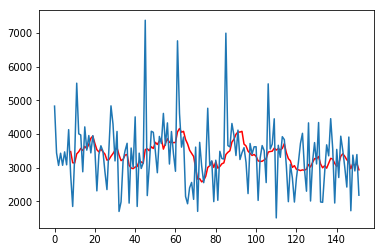

In [38]:
plt.plot(rolmean, color='red')
plt.plot(series['PAX'])


In [16]:
# arena = df.select(['Data_Venda', 'PAX']).filter(df['Local_de_Venda'] == 'Ellipsis').groupBy('Data_Venda').sum()
# arena = arena.withColumnRenamed(existing='sum(PAX)', new='PAX')
# arena

In [17]:
import pandas.util.testing as tm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from numpy import sqrt
from sklearn.metrics import mean_squared_error


In [18]:
# Prepares the dataframe
def parseFieldToDate(data, dateCol):
    data = data.toPandas()
    data[dateCol] = pd.to_datetime(data[dateCol]).dt.date
    data = data.sort_values(dateCol)
    data = data.set_index(dateCol).asfreq('d')
    return data


In [19]:
series = parseFieldToDate(series, 'Data_Venda')

##### Autocorrelation can help us to find how many lags are correlated

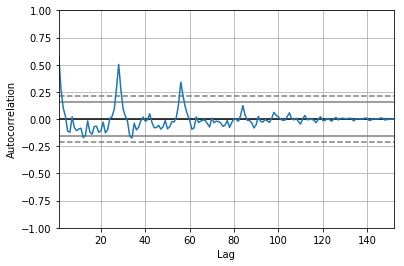

In [22]:
autocorrelation_plot(series)
plt.show()

#### The graphs shows that there is some relevant correlation for the datas between 30 days of difference

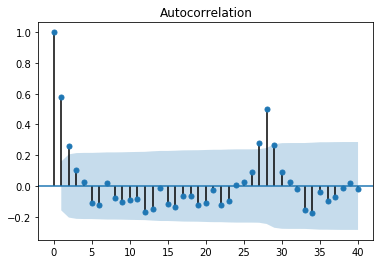

In [23]:

plot_acf(series, lags=40)
plt.show()

In [24]:
#Helper functios
def splitTestTrain(data, amount):
    X = data.values
    X = X.astype('float32')

    size = int(len(X) * amount)

    train = X[0:size]
    test =  X[size:]
    
    return train, test

#Transforms it to stationary
def difference(dataset, interval=1):
  diff = list() 
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return diff

# Rescale data back to it's original
def inverse_difference(history, previsao, interval=1):
  return previsao + history[-interval]

def testModel(test, train , modelOrder=(1,1,1), interval = 1):
    
    history = [x for x in train]
    # cria lista de previsões
    predictions = list()
    
    for t in range(len(test) ):

       
      diff = difference(history, interval)
  
      model = ARIMA(diff, order=modelOrder)

      model_fit = model.fit(trend='nc', disp=0)

      # a variável valor_predito recebe o valor previsto pelo modelo
      predictValue = model_fit.forecast()[0]

      # valor_predito recebe o valor revertido (escala original)
      predictValue = inverse_difference(history, predictValue, interval)

      # adiciona o valor predito na lista de predicões
      predictions.append(predictValue)
    
      # a variável valor_real recebe o valor real do teste
      realValue = test[t]

      # adiciona o valor real a variável history
      history.append(realValue)

      # imprime valor predito e valor real
    #   print('Valor predito=%.3f, Valor esperado=%3.f' % (valor_predito, valor_real))
    # Avaliando os resultados

    rmse = sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.3f' % rmse)
    # plot forecasts against actual outcomes 
    plt.plot(test)
    plt.plot(predictions, color='red')
    plt.show()

#### Lets test some models to see which one fits the best

Test RMSE: 905.007


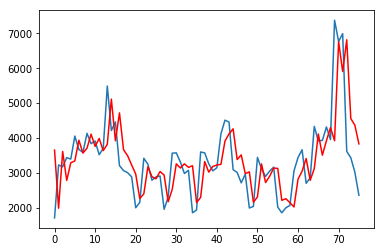

In [26]:

train, test = splitTestTrain(series, 0.5)

testModel(train,test,(3,1,1), 1)


#### Now, make the forecast

In [30]:
forecastDay = 15
modelOrder=(3,1,1)

train, test = splitTestTrain(series, 1)

# cria a variável history
history = [x for x in train]
# cria lista de previsões
predictions = list()



for t in range(len(train)):

      # difference data
      interval = 1
      diff = difference(history, interval)

      # cria um modelo ARIMA com os dados de history
      model = ARIMA(diff, order=modelOrder)

      # treina o modelo ARIMA
      model_fit = model.fit(trend='nc', disp=0)

      # a variável valor_predito recebe o valor previsto pelo modelo
      valor_predito = model_fit.forecast()[0]
      

        # valor_predito recebe o valor revertido (escala original)
      valor_predito = inverse_difference(history, valor_predito, interval)

      # adiciona o valor predito na lista de predicões
      predictions.append(valor_predito)

      # a variável valor_real recebe o valor real do teste
      if(t > len(train)):
        history.append(valor_predito)



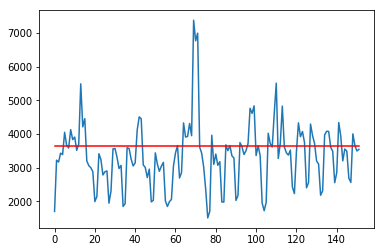

In [31]:
plt.plot(history)
plt.plot(predictions, color='red')
